# Setup

In [ ]:
%load_ext autoreload
%autoreload 2

import os
import re
import pickle
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.sparse import issparse
from pymer4.models import lmer, lm, glmer, compare
from pymer4 import config
import polars
import statsmodels.api as sm
import senepy
import gseapy as gp
import pertpy as pt
import warnings
import scanpy as sc
import pandas as pd
import numpy as np
import scflow
from scflow.ax import find_senescence_genes, run_senepy

# Display Settings
pd.set_option("display.max_rows", 500)  # or None for unlimited rows
pd.set_option("display.max_columns", 100)
pd.set_option("display.max_colwidth", 100)
pd.set_option("display.width", 300)
mpl.rcParams["figure.dpi"] = 200
warnings.filterwarnings(
    "ignore", message="Bitwise inversion '~' on bool is deprecated",
    category=DeprecationWarning)

# If You Want Results Emailed (Will Overwrite HTML Regardless of `overwite`)
cur_file = os.path.join(os.path.abspath(""), "data_diagnostics_613.ipynb")
html_out = os.path.splitext(cur_file)[0] + ".html"
email = "elizabeth.aslinger@aya.yale.edu"
# set email to None to skip

# Cell Type Label Column
col_celltype = "annotation_by_overlap"
# col_celltype = "Annotation_ToppGene"
# col_celltype = "cellmap_class_name"
# col_celltype = "cellmap_class_name_collapsed"

# Metadata Information
species = "Mouse"
col_sample, col_batch = "sample", "Group"
# col_age = "Characteristics[Age at Euthanasia]"
# col_condition = "Factor Value[Spaceflight]"
col_age = "Age_End"
col_condition = "Condition"
group_order = ["Ground Control | 12 Weeks", "Ground Control | 29 Weeks",
               "Space Flight | 12 Weeks", "Space Flight | 29 Weeks"]
# group_order = ["Ground Control | 20 Weeks", "Ground Control | 37 Weeks",
#                "Space Flight | 20 Weeks", "Space Flight | 37 Weeks"]
keys = {col_condition: dict(key_control="Ground Control",
                            key_treatment="Space Flight"),
        # col_age: dict(key_control="20 Weeks",
        #               key_treatment="37 Weeks"),
        col_age: dict(key_control="12 Weeks",
                      key_treatment="29 Weeks"),
        col_batch: dict(key_control=group_order[0],
                        key_treatment=group_order[1:])}
palette = {col_condition: {keys[col_condition]["key_control"]: "b",
                           keys[col_condition]["key_treatment"]: "r"},
           col_age: {keys[col_age]["key_control"]: "g",
                     keys[col_age]["key_treatment"]: "y"},
           col_batch: dict(zip(group_order, ["c", "b", "tab:pink", "r"]))}

# Markers
mks_a_priori = pd.read_csv("GL-DPPD-7111_Mmus_Brain_CellType_GeneMarkers.csv")
mks_a_priori.loc[:, "cellName"] = mks_a_priori.cellName.replace({
    "Oligodendrocyte precursor cell": "OPC"}).apply(
        lambda x: " ".join([i.capitalize() for i in re.sub(
            " cell", "", x).split(" ")])).replace({
                "Opc": "OPC"})  # capitalize cell names
mks_a_priori = mks_a_priori.set_index("cellName")["geneSymbol"]
mks_a_priori = dict(mks_a_priori.apply(lambda x: set(x.split(","))))
mks_a_priori.update({
    "Neuroepithelial": {"Nes", "Notch1", "Sox2", "Sox10", "Hes1", "Hes3"},
    "Excitatory": {"Slc17a7", "Slc30a3", "Tcf4",
                   "Slc17a6", "Slc6a1", "Baiap3",
                   "Grin1", "Grin2b", "Gls"},
    "Inhibitory": {"Gad1", "Slc6a1", "Gabbr1", "Gabbr2",
                   "Gad2", "Slc32a1", "Oprm1", "Htr2c"},
    # "Glutamatergic": {"Slc17a7", "Slc17a6", "Grin1", "Grin2b", "Gls"},
    # "GABAergic": {"Slc6a1", "Gabbr1", "Gabbr2", "Gad2", "Gad1"},
    # "Dopaminergic": {"Th", "Dat", "Foxa2", "Girk2", "Nurr1", "Lmx1b"},
    # "Serotonergic": {"Tph", "Sert", "Pet1"},
    # "Cholinergic": {"ChAT", "VAChT", "Acetylcholinesterase"}
})

# Scoring Metrics
use_metric = "senmayo"
percentile = 1

# File Input & Output
file_path = "data/OSD-613_integrated_analyzed.h5ad"

# Load Data
self = scflow.Rna(file_path, col_sample=col_sample, col_batch=col_batch,
                  col_celltype=col_celltype)  # data
self.rna.obs.loc[:, col_batch] = self.rna.obs[col_batch].astype(
    pd.CategoricalDtype(categories=group_order, ordered=True))
self.rna.obs.loc[:, "Spaceflight"] = (self.rna.obs[col_condition] == keys[
    col_condition]["key_treatment"]).astype(int)  # 1 vs. 0 spaceflight
self.rna.obs.loc[:, "Aged"] = (self.rna.obs[col_age] == keys[
    col_age]["key_treatment"]).astype(int)  # 1 vs. 0 older
self.rna = self.rna[:, self.rna.var.mt == False]  # snRNA-seq so remove MT-
self.rna = self.rna[:, self.rna.var.ribo == False]  # snRNA-seq so remove RB-

# Hierarchical
keys_cts = {"Neuron": ["Excitatory", "Inhibitory", "Excitatory-Inhibitory"],
            "Macroglia": ["Oligodendrocyte", "OPC", "Astrocyte"],
            "Microglia": ["Microglial"]}
key_cts = dict(pd.concat([pd.Series(dict(([(i, x) for i in keys_cts[
    x]]))) for x in keys_cts]))
self.rna.obs.loc[:, f"{col_celltype}_hierarchy"] = self.rna.obs[
    col_celltype].replace(key_cts)
self.rna.raw = None

# Display Object
print(self.rna)
print(self.rna.obs.groupby(col_sample).describe())
self.rna.obs

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [ ]:
percentile = 1

sc.tl.score_genes(self.rna, marker_gene_sets.loc["Senmayo"],
                  ctrl_as_ref=True, ctrl_size=50, gene_pool=None,
                  n_bins=25, score_name="score_senmayo", random_state=0,
                  copy=False, use_raw=None, layer="log1p")

# Determine Threshold
perc_s, perc = str(100 - percentile) + "%", 1 - (percentile / 100)
p_h = 3
perc_s_h, perc_h = str(100 - p_h) + "%", 1 - (p_h / 100)
print("Percentile for Threshold:", perc_s)
for u in sen_metrics:
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc])[perc_s], include_groups=False).to_frame(
                    f"Senescence_Threshold_{u}"), on=col_celltype).loc[
                        self.rna.obs.index]
    self.rna.obs = self.rna.obs.join(self.rna.obs[self.rna.obs[
        col_batch] == keys[col_batch]["key_control"]].groupby(
            col_celltype).apply(lambda x: x[f"score_{u}"].describe(
                percentiles=[perc_h])[perc_s_h],
                                include_groups=False).to_frame(
                                    f"Senescence_Threshold_{u}_{p_h}"),
                                on=col_celltype).loc[self.rna.obs.index]

# Binary CLassification
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_{x}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}"])
    self.rna.obs.loc[:, f"Senescent_Cell_{x}_{p_h}"] = (self.rna.obs[
        f"score_{x}"] >= self.rna.obs[f"Senescence_Threshold_{x}_{p_h}"])

# String Labels (for Plotting/Categorical Analysis)
for x in sen_metrics:
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_{x}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_{x}_{p_h}"] = self.rna.obs[
        f"Senescent_Cell_{x}_{p_h}"].astype(bool).astype(str).replace({
            "True": "Senescent", "False": "Non-Senescent"})
    self.rna.obs.loc[:, f"Senescent_Cell_Label_by_Type_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype].astype(str)
    self.rna.obs.loc[:, f"SnC_hierarchy_{x}"] = self.rna.obs[
        f"Senescent_Cell_Label_{x}"].replace({
            "Senescent": "SnC ", "Non-Senescent": ""}) + self.rna.obs[
                col_celltype + "_hierarchy"].astype(str)

# Descriptives
for x in sen_metrics:
    print(x, round(self.rna.obs[[
        f"Senescent_Cell_Label_{x}", col_celltype]].value_counts(
            normalize=True).sort_index() * 100, 1).unstack(0))


# Choose Metrics for Main Analysis
for x in ["Senescent_Cell_Label", "Senescent_Cell", "SnC_hierarchy",
            "Senescence_Threshold", "Senescent_Cell_Label_by_Type"]:
    self.rna.obs.loc[:, x] = self.rna.obs[f"{x}_{use_metric}"]
self.rna.obs.loc[:, "senscore"] = self.rna.obs[f"score_{use_metric}"]
genes = marker_gene_sets.loc["Senmayo"] if (
    use_metric == "senmayo") else genes_senepy

# Number of Cells

In [68]:
%matplotlib inline

# Cells per Cluster
perc_clusters = round(100 * self.rna.obs.groupby(col_sample).value_counts(
    [col_celltype], normalize=True).unstack(1), 2)
print(f"\n\n*** Cell Composition (%) ***\n\n{perc_clusters}")

# Number of Cells
n_cells = self.rna.obs.groupby(col_sample).apply(
    lambda x: x.n_cells_original_sample.unique()[0],
    include_groups=False).to_frame("Original Cell N").join(
        self.rna.obs.groupby(col_sample).apply(
            lambda x: x.shape[0], include_groups=False).to_frame("N Cells"))
n_cells.loc[:, "Percent_Filtered"] = round(100 * (1 - n_cells[
    "N Cells"] / n_cells["Original Cell N"]), 2)
print("\n\n", n_cells.sort_values("Percent_Filtered"))



*** Cell Composition (%) ***

annotation_by_overlap         Excitatory  Inhibitory  Microglial  Oligodendrocyte  Astrocyte   OPC  Excitatory-Inhibitory
sample                                                                                                                   
RRRM2_BRN_GC_ISS-T_YNG_GY4         33.76       30.25        3.95            16.18      11.46  2.52                   1.88
RRRM2_BRN_GC_ISS-T_YNG_GY9         26.42       37.53        4.21            16.60      10.01  3.60                   1.63
RRRM2_BRN_GC_ISS-T_OLD_GO18        32.16       37.08        4.74            13.69       9.28  3.05                   0.00
RRRM2_BRN_FLT_ISS-T_OLD_FO20       31.82       25.68        4.37            25.25       8.19  3.51                   1.18
RRRM2_BRN_GC_ISS-T_OLD_GO19        26.29       40.30        4.39            18.09       7.52  3.38                   0.03
RRRM2_BRN_GC_ISS-T_OLD_GO13        19.81       30.43        3.50            27.48      11.52  3.70                

# Markers

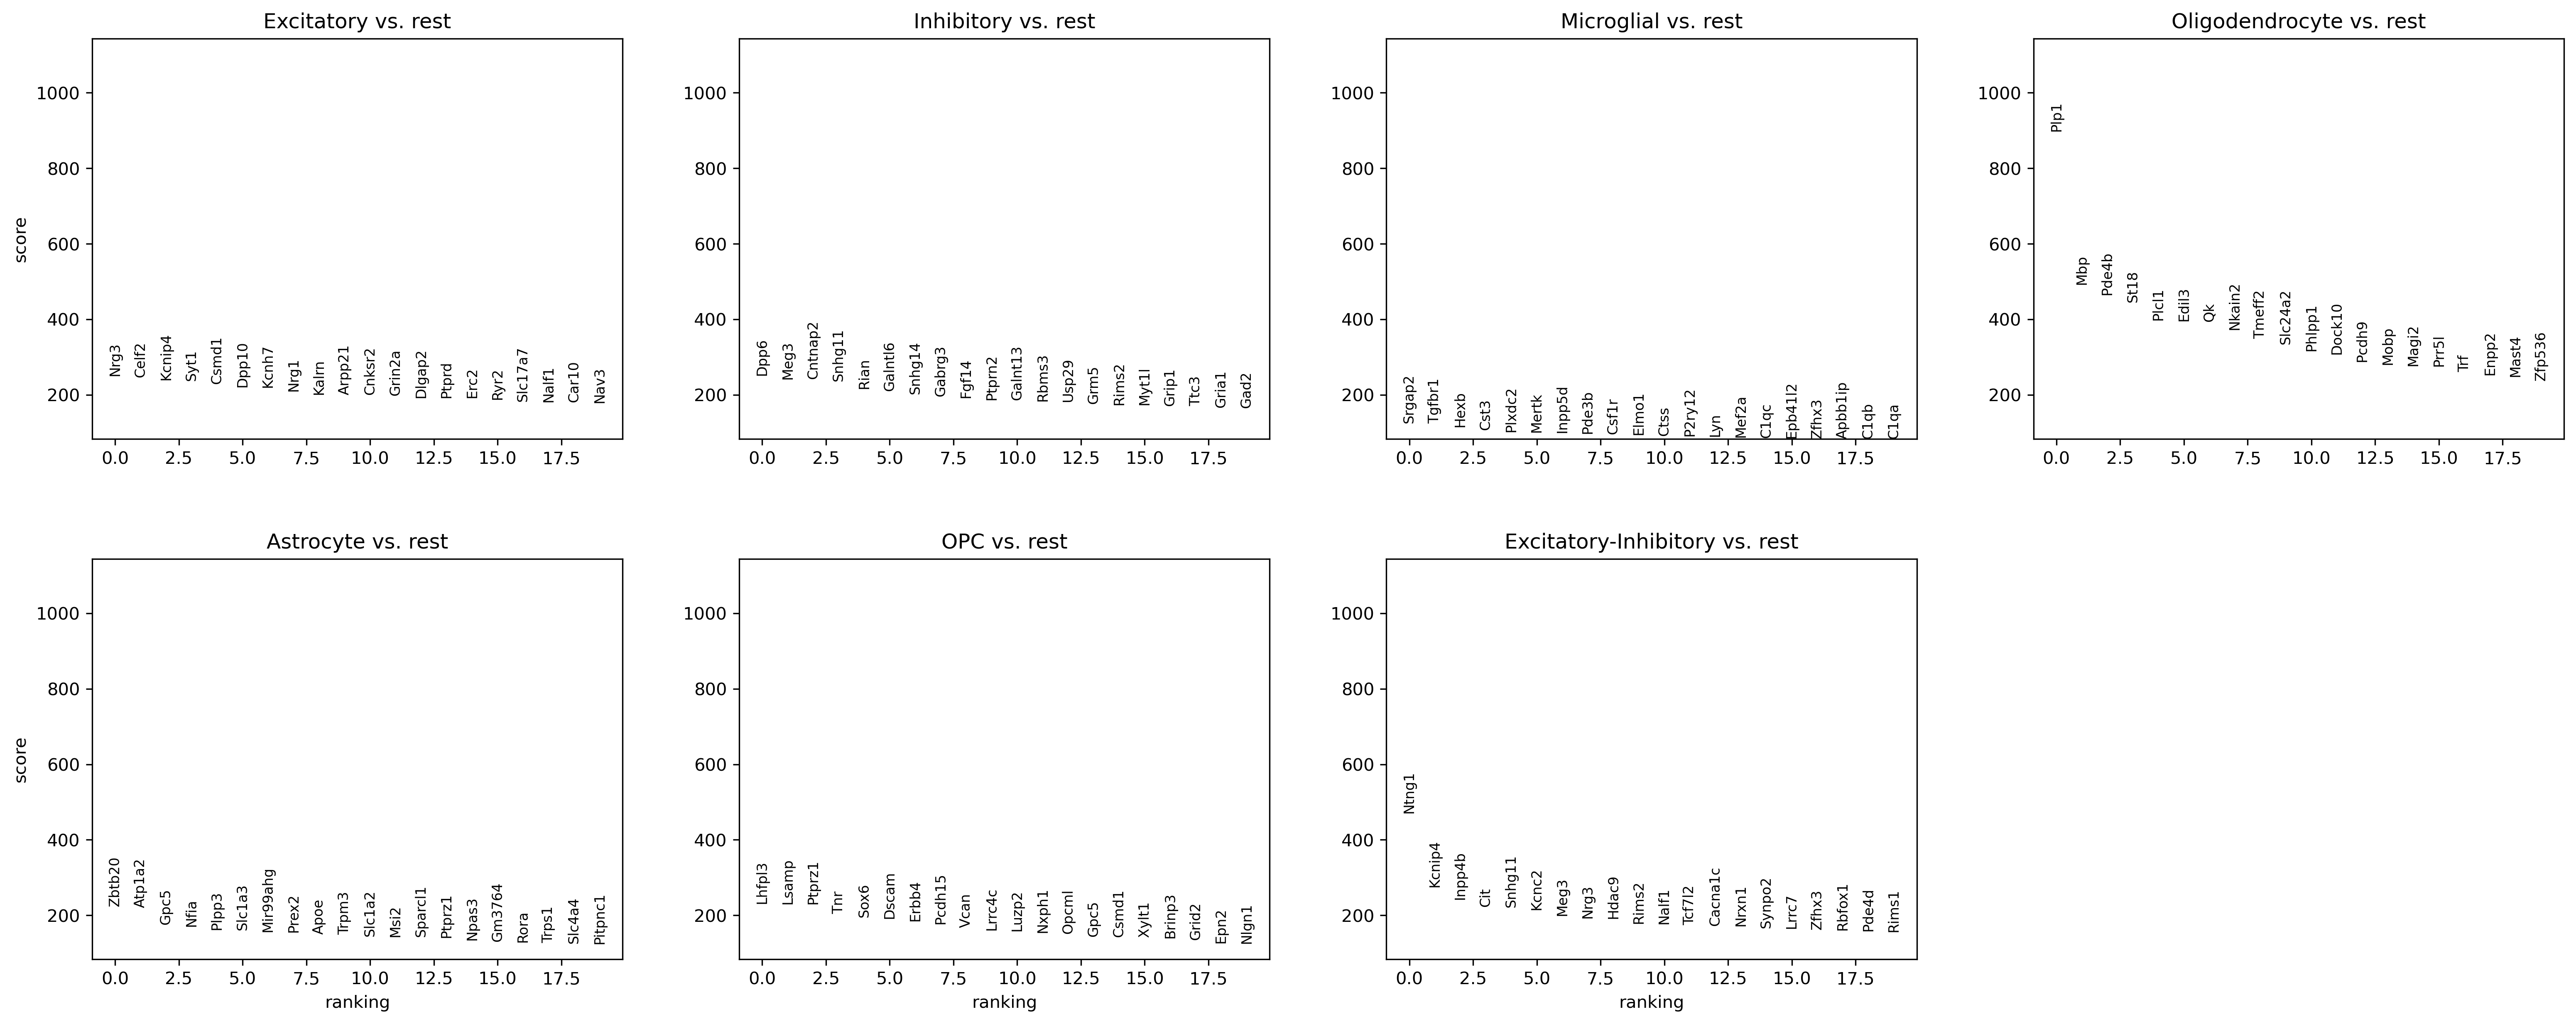

scores  logfoldchanges  pvals  pvals_adj
annotation_by_overlap names                                                    
Astrocyte             Nim1k         47.064068        2.660807    0.0        0.0
                      Pbxip1        45.993198        4.411093    0.0        0.0
                      Aldh1l1       46.067970        4.603257    0.0        0.0
                      Dpf3          46.307438        3.016120    0.0        0.0
                      Daam2         46.455727        1.975826    0.0        0.0
                      Mid1          46.547459        3.147870    0.0        0.0
                      Gm26512       46.596172        4.866727    0.0        0.0
                      Gk            46.619812        2.358266    0.0        0.0
                      Cd81          46.993855        1.585176    0.0        0.0
                      Slc25a18      47.046139        5.114295    0.0        0.0
Excitatory            Slc8a2        59.332294        1.443789    0.0        0.0
                      Gm37407       57.852417        1.410103    0.0        0.0
                      Kcnh3         57.889107        1.536317    0.0        0.0
                      Gm14636       57.946537        1.525387    0.0        0.0
                      Gm32014       58.233006        1.695849    0.0        0.0
                      Camkk2        58.635632        1.083039    0.0        0.0
                      Ttll11        58.691746        1.000857    0.0        0.0
                      Cckbr         58.886806        2.774496    0.0        0.0
                      Jph1          58.890182        1.159974    0.0        0.0
                      Svop          59.070915        1.028893    0.0        0.0
Excitatory-Inhibitory Megf9         52.264030        1.840525    0.0        0.0
                      Rasgrf1       51.559391        1.407420    0.0        0.0
                      Scn8a         51.671570        1.217524    0.0        0.0
                      Ero1b         51.785263        2.660792    0.0        0.0
                      Prox1         51.929565        2.830664    0.0        0.0
                      Dclk2         51.945118        1.769940    0.0        0.0
                      Bmerb1        51.960815        1.737643    0.0        0.0
                      Ndrg4         51.976624        1.431685    0.0        0.0
                      Dpp10         51.992775        1.159351    0.0        0.0
                      Nmt2          52.006741        1.669954    0.0        0.0
Inhibitory            Zmym3         51.089523        1.472235    0.0        0.0
                      Hrh3          51.470680        1.819407    0.0        0.0
                      N4bp2l1       51.454659        1.068241    0.0        0.0
                      Mapkbp1       51.437759        1.257416    0.0        0.0
                      Ankrd24       51.367485        1.475215    0.0        0.0
                      Inha          51.344063        1.437878    0.0        0.0
                      Ptchd1        51.340122        1.324198    0.0        0.0
                      Fam184a       51.302254        1.008869    0.0        0.0
                      Tubb3         51.190762        1.002810    0.0        0.0
                      Gsdme         51.117599        1.411772    0.0        0.0
Microglial            Srgap2       125.218414        4.258848    0.0        0.0
                      Tgfbr1       124.597107        7.077548    0.0        0.0
                      Slco2b1       64.663284        8.772433    0.0        0.0
                      Lrmda         63.890797        4.024502    0.0        0.0
                      Runx1         63.617565        8.941139    0.0        0.0
                      Sparc         63.424152        4.695066    0.0        0.0
                      Gpr34         62.981968        8.188069    0.0        0.0
                      Maml3         62.937141        3.282756    0.0        0.0
                      Rreb1         62.

In [75]:
self.find_markers(col_celltype=col_celltype)
df_degs = self.get_markers_df(
    n_genes=50, col_celltype=col_celltype,
    log2fc_threshold=1, p_threshold=1e-10)
df_degs.groupby(col_celltype).apply(
    lambda x: x.head(10)).reset_index(0, drop=True)

## *A Priori* Marker GEX

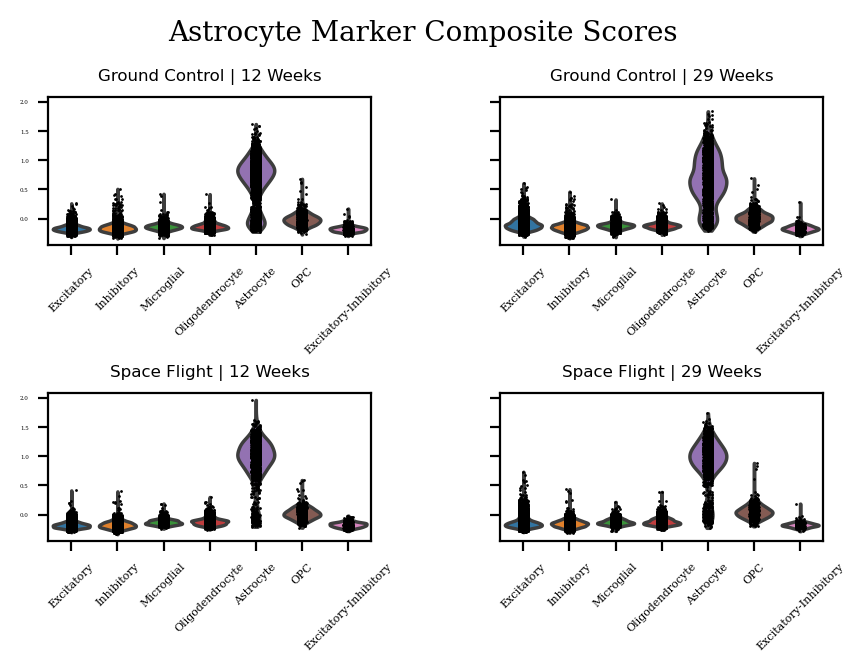

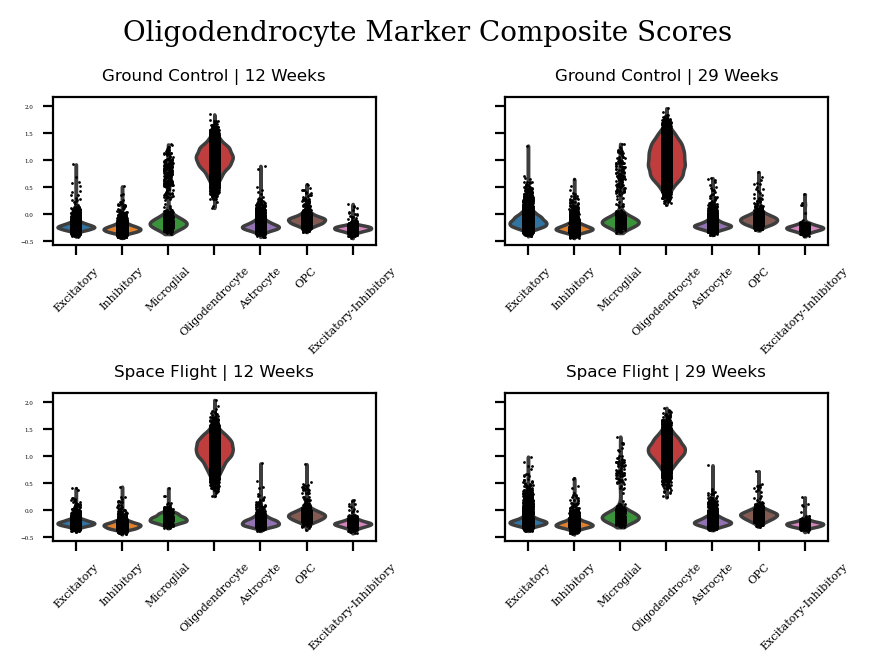

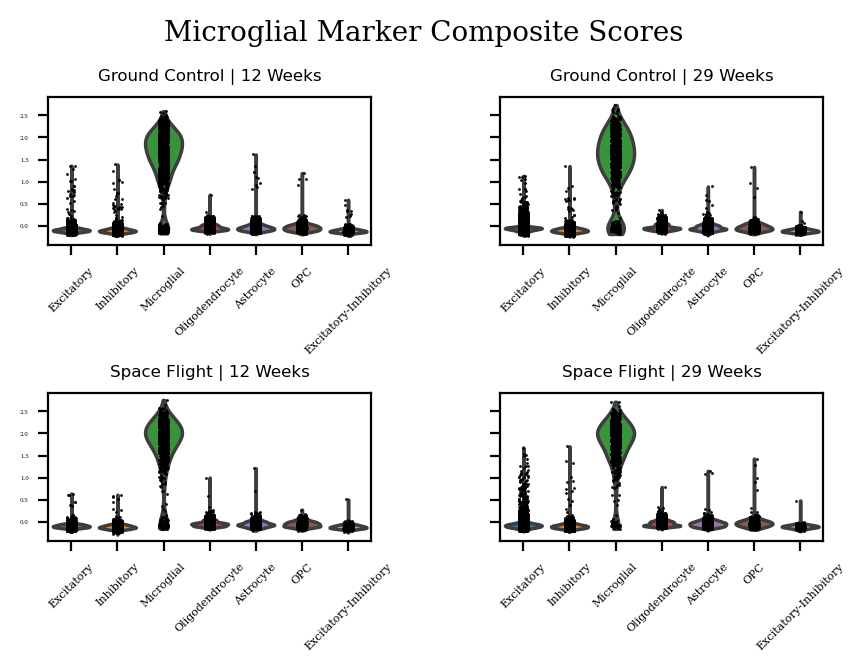

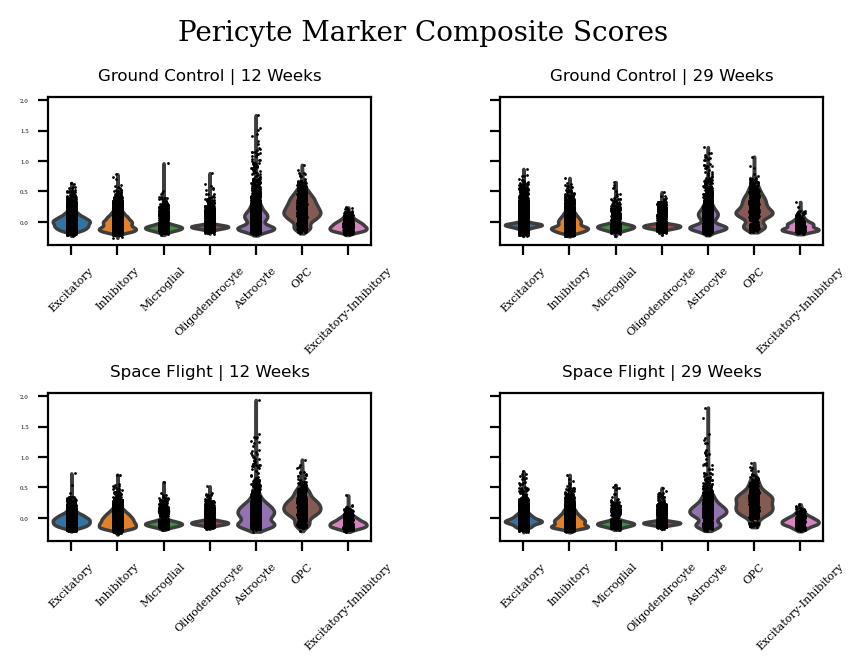

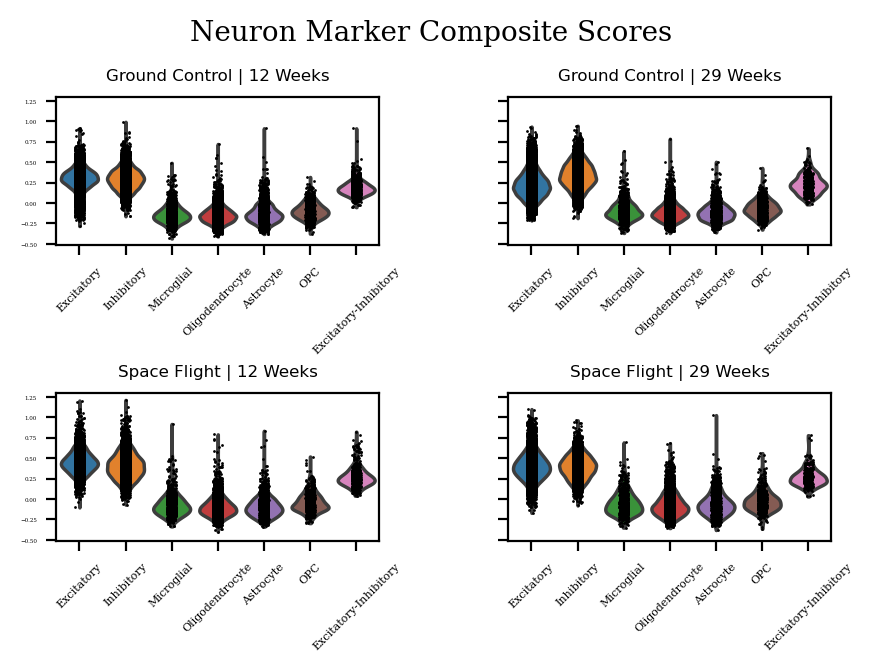

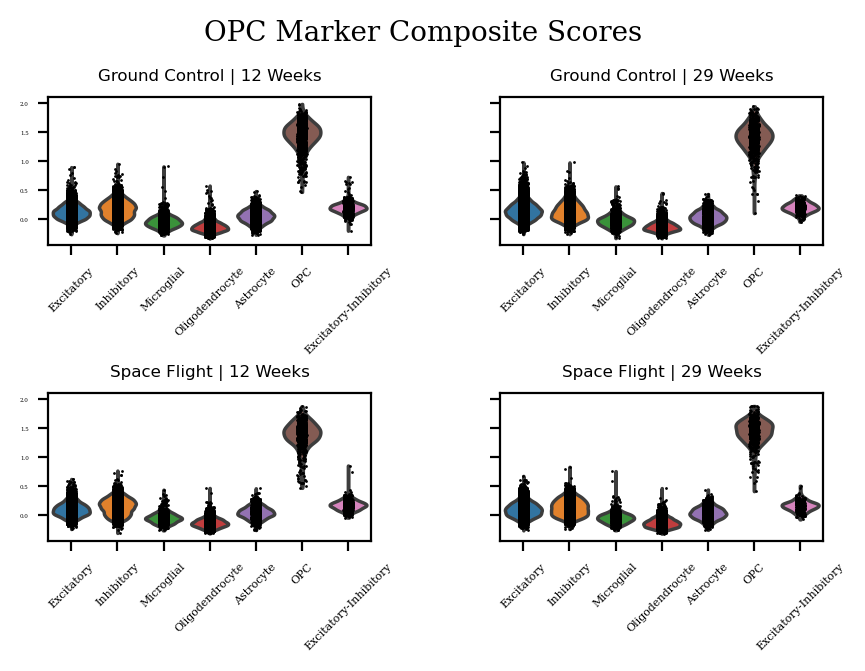

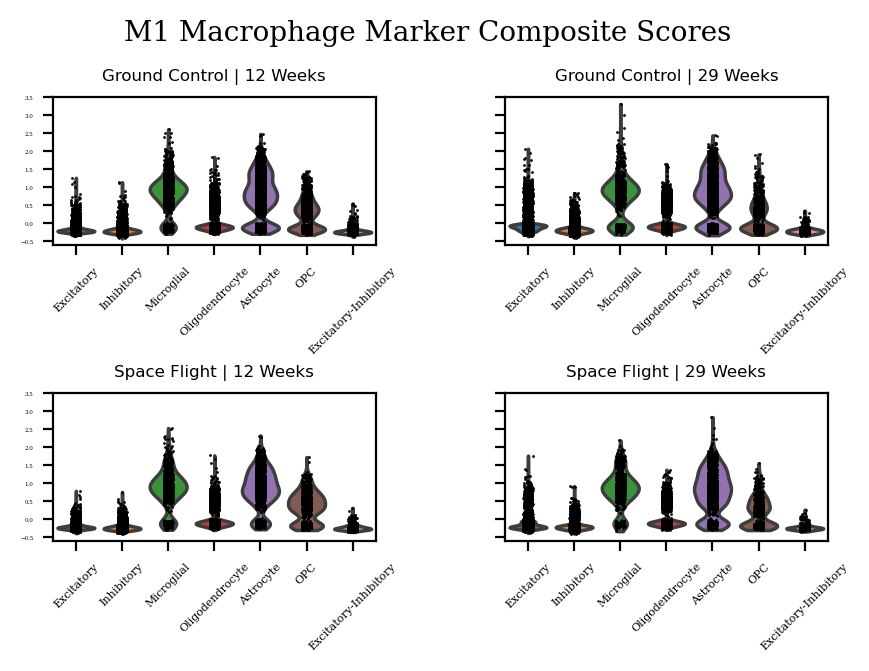

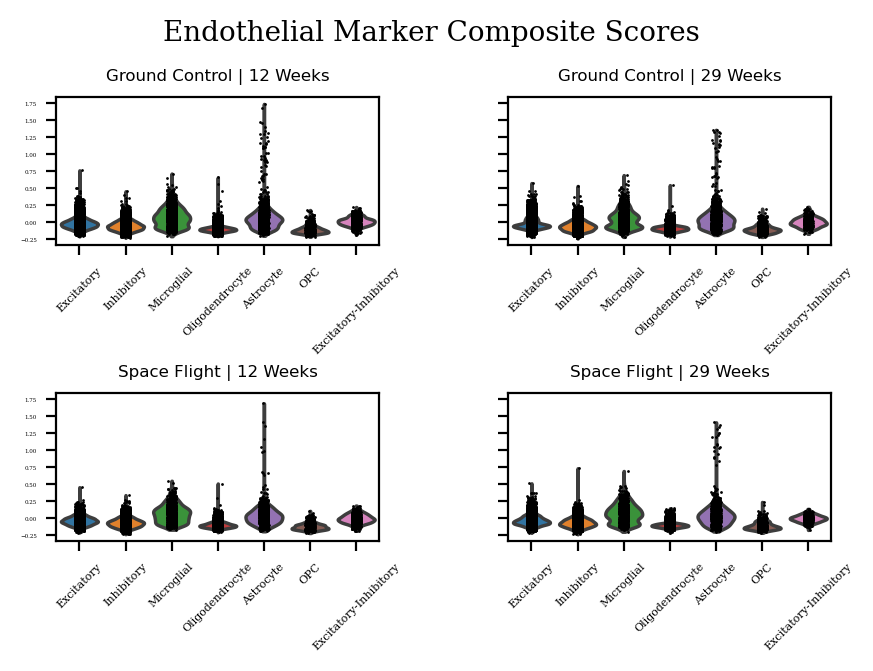

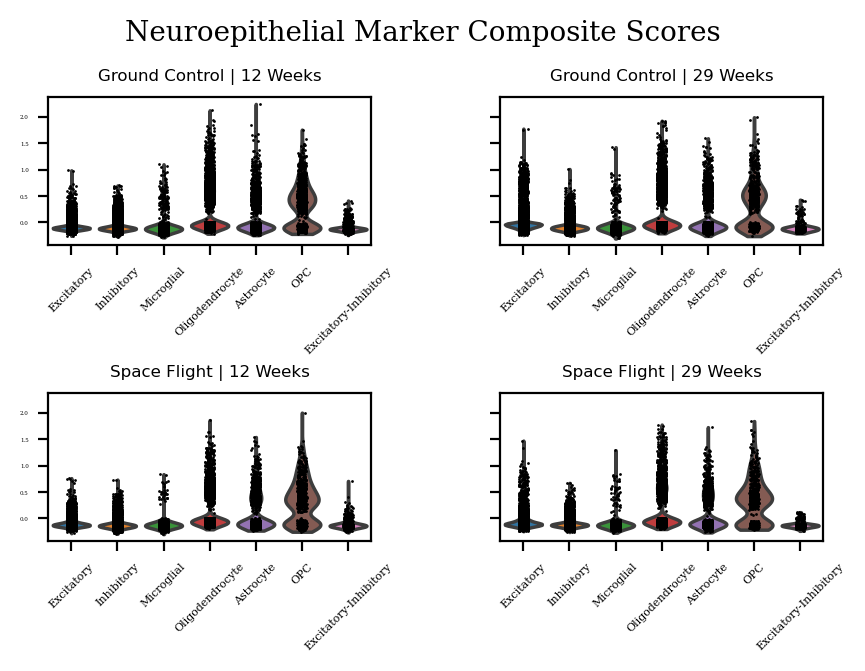

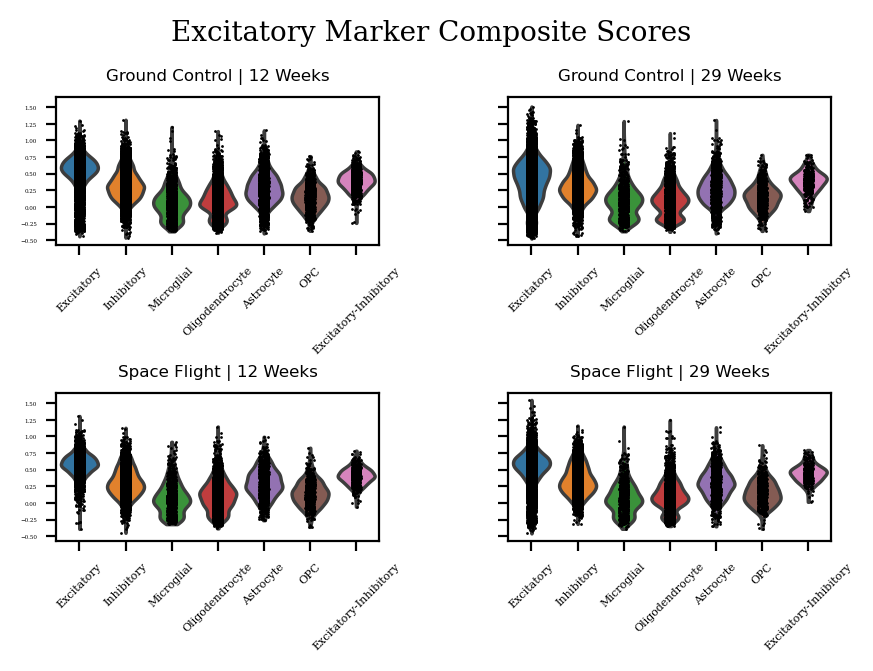

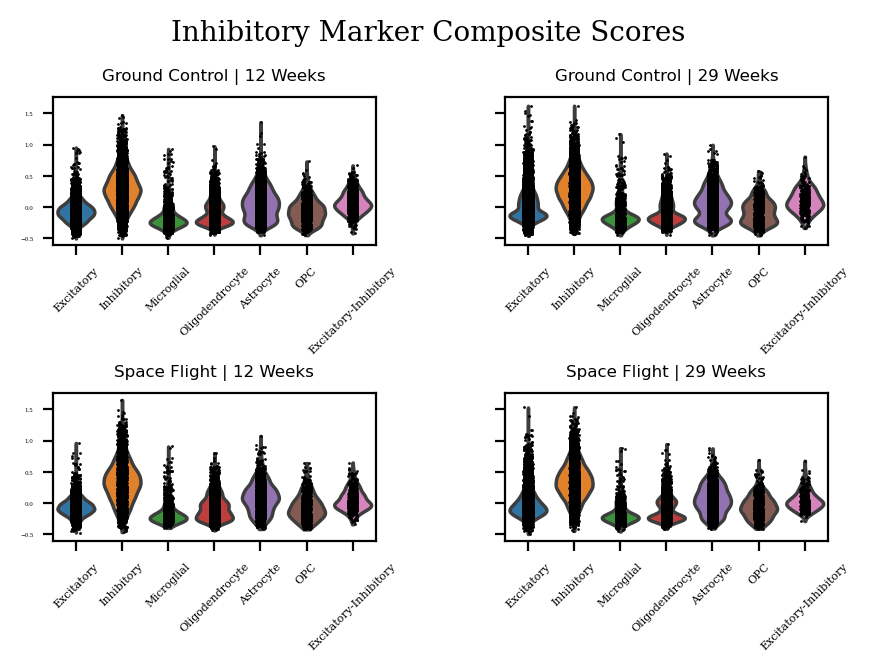

In [142]:
for x in mks_a_priori:
    # ggg = mks_a_priori[x].intersection(self.rna.var_names)
    # _ = self.plot(
    #     kind="violin", col_celltype=col_celltype, layer="scaled", genes=ggg,
    #     figsize=(len(ggg) * 2, len(ggg)), rotation=45, col_wrap=True,
    #     hspace=0.5 if len(ggg) < 10 else 1 if len(ggg) < 15 else 1.5,
    #     title=x, top=0.95)
    ggg = mks_a_priori[x].intersection(self.rna.var_names)
    sc.tl.score_genes(self.rna, gene_list=list(ggg),
                      layer="log1p", score_name=f"score_markers_{x}")
    _ = scflow.pl.plot_violin_by_group(
        self.rna, f"score_markers_{x}",
        fontsize={"title": "medium", "subtitle": 6, "x": 4,
                  "y": 2, "ylabel": None},
        col_celltype=col_celltype, col_condition=col_batch,
        layer="scaled", rotation=45, figsize=(5, 3), wspace=0.4,
        hspace=1, title=f"{x} Marker Composite Scores", top=0.85, sharey=True)

## Excitatory-Inhibitory Marker GEX

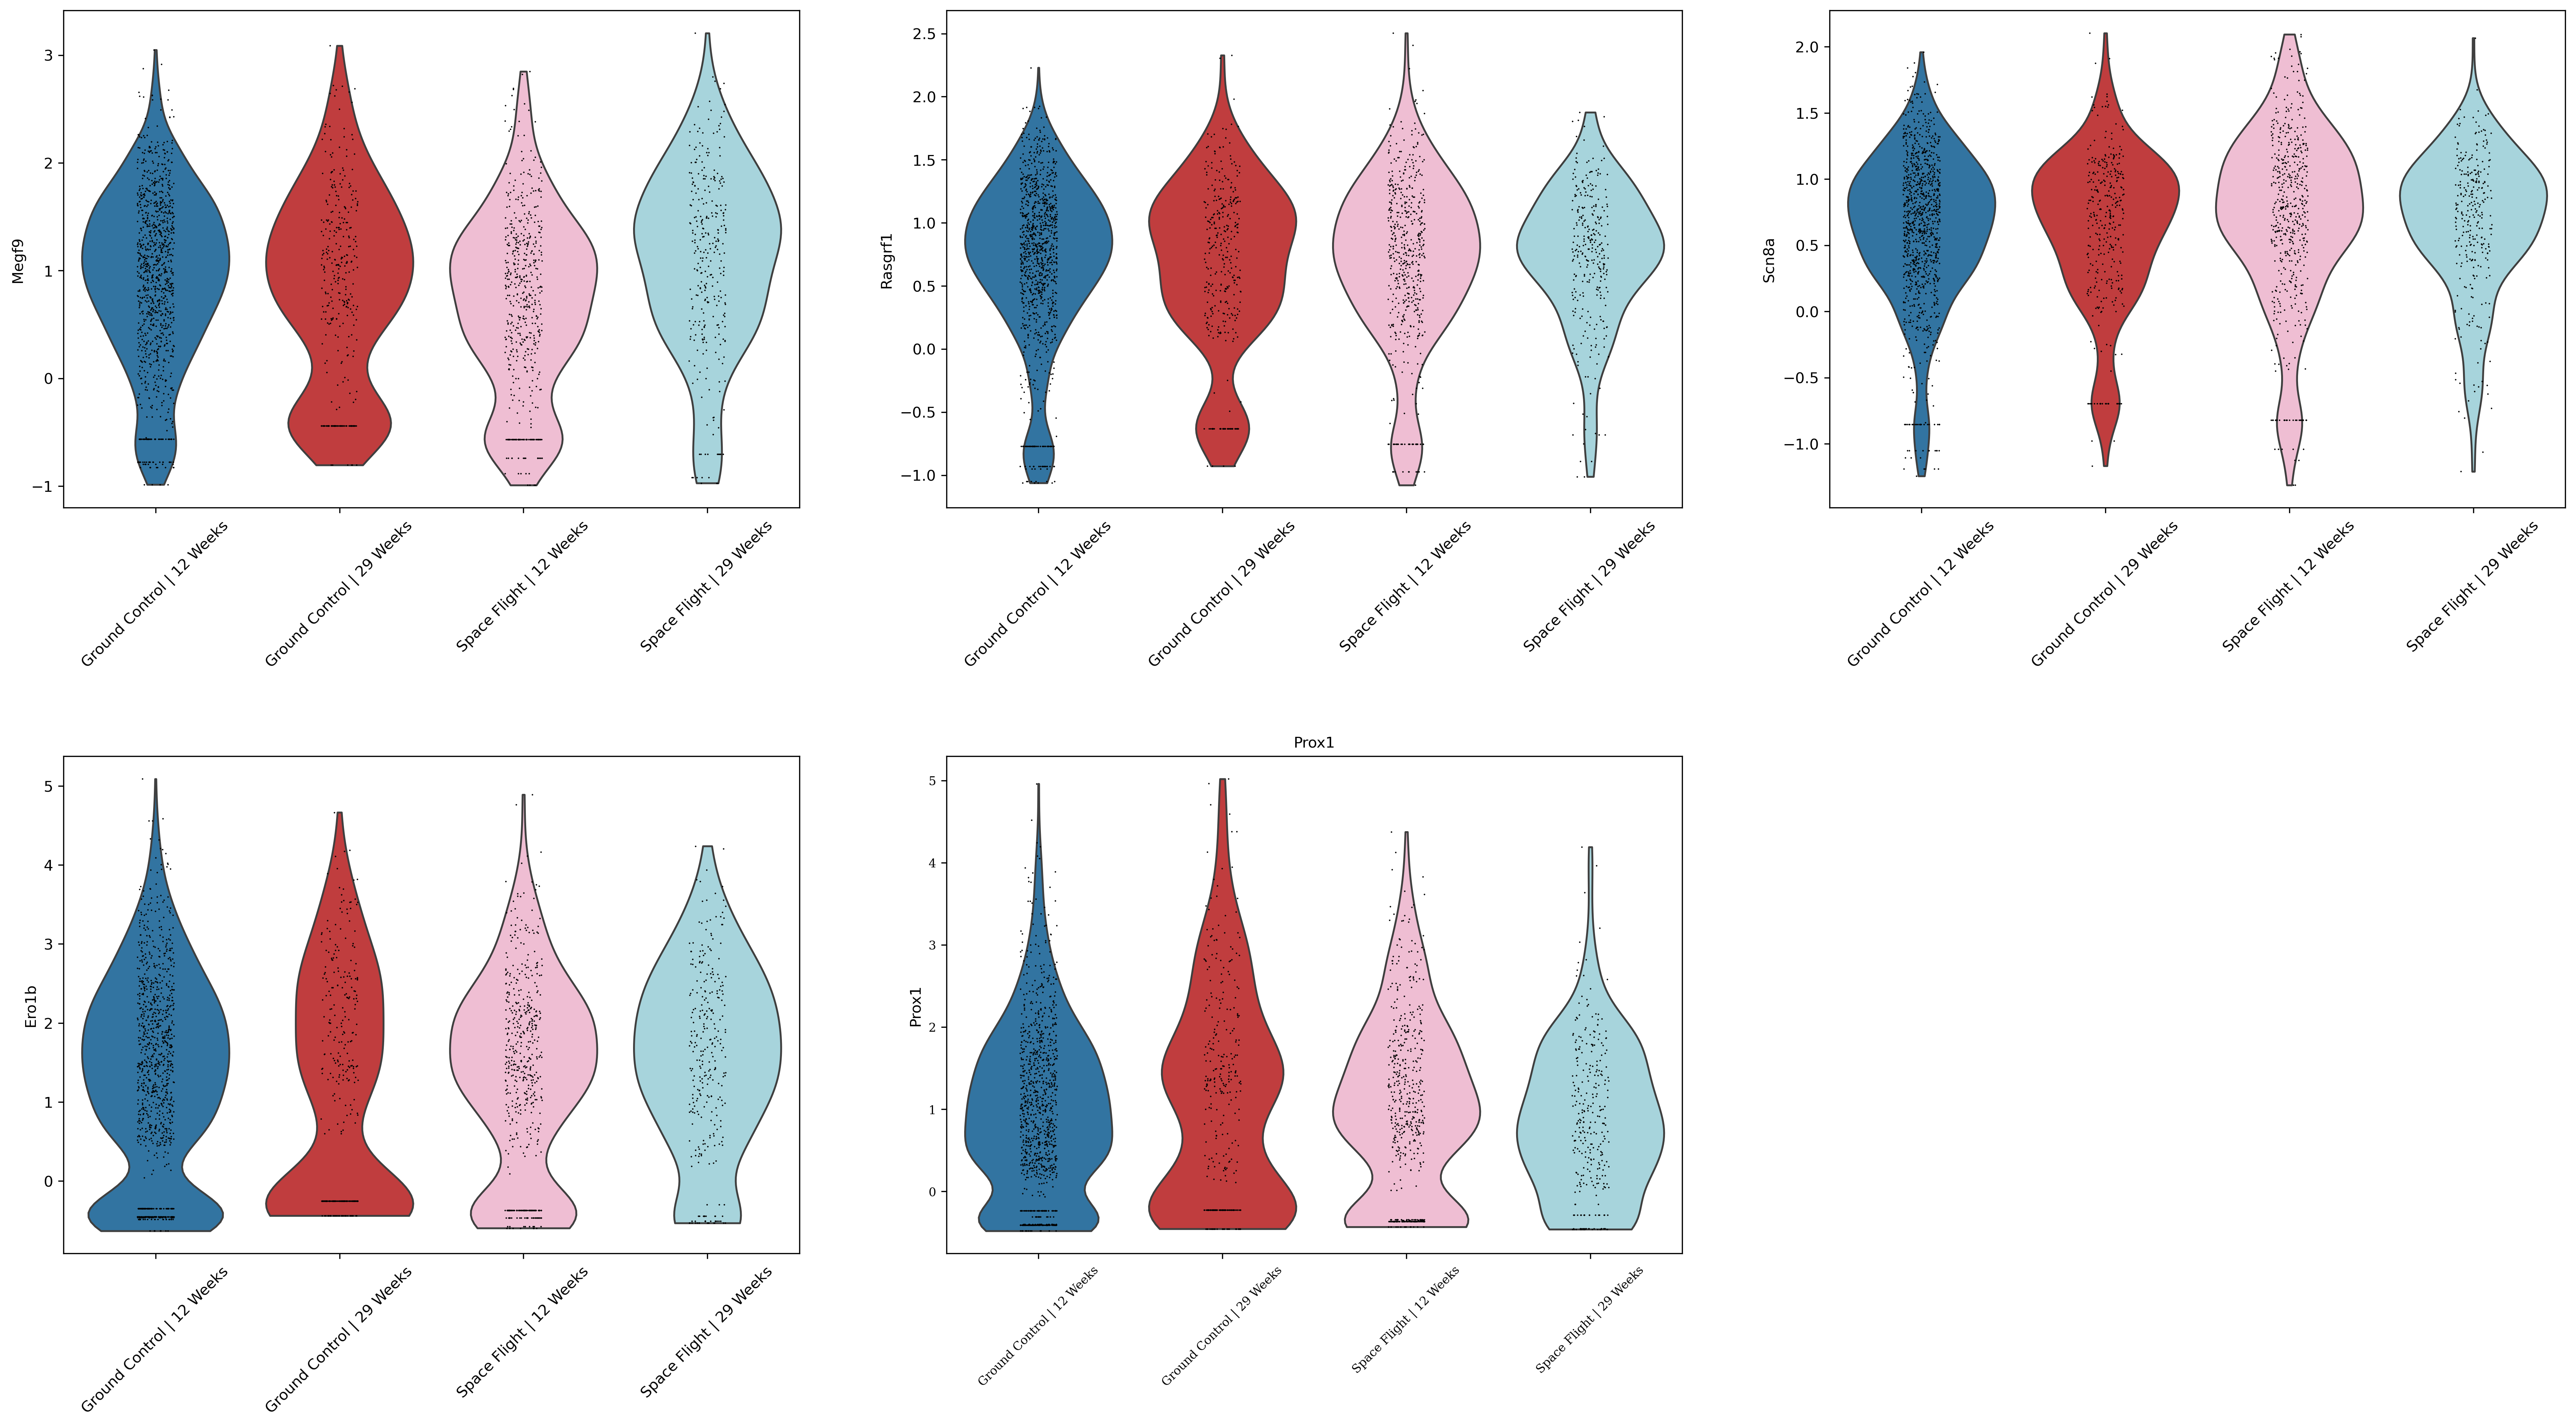

In [137]:
_ = self.plot(kind="violin", col_celltype=col_batch, layer="scaled",
              genes=df_degs.loc["Excitatory-Inhibitory"].index.values[:5],
              subset=self.rna.obs[col_celltype] == "Excitatory-Inhibitory",
              figsize=(30, 15), rotation=45, col_wrap=True, hspace=0.5)

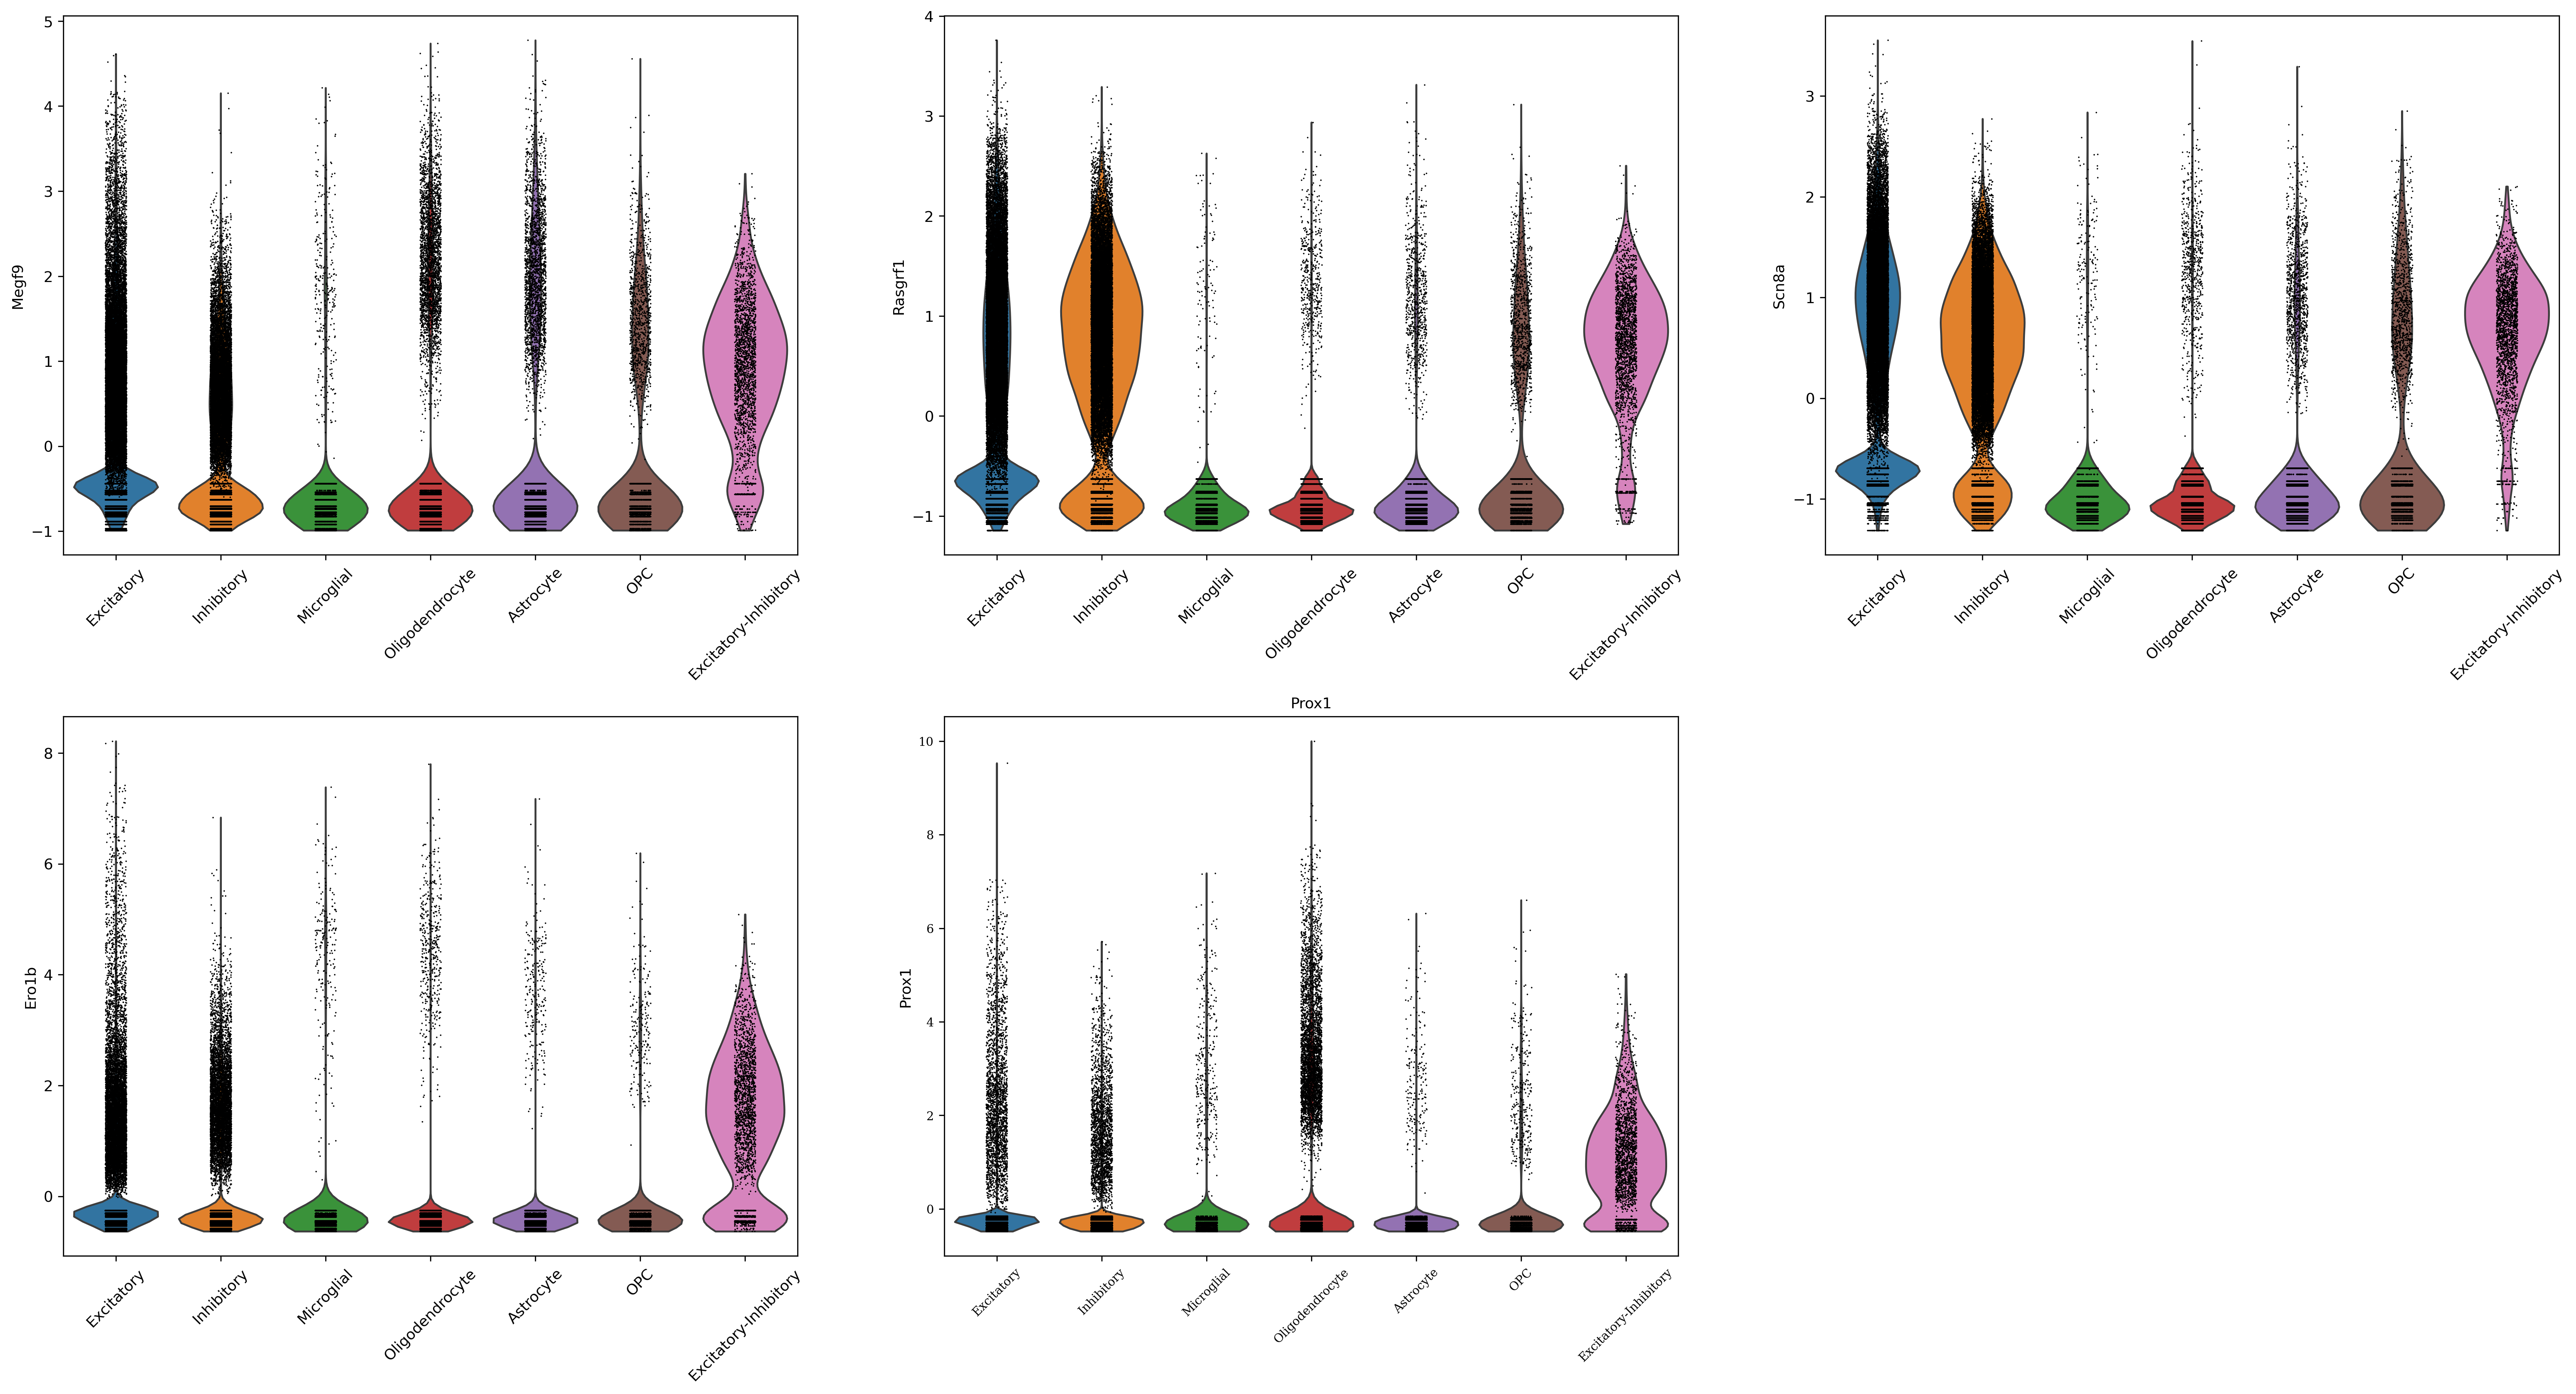

In [138]:
_ = self.plot(kind="violin", col_celltype=col_celltype, layer="scaled",
              genes=df_degs.loc["Excitatory-Inhibitory"].index.values[:5],
              figsize=(30, 15), rotation=45, col_wrap=True, hspace=0.3)